#❗ Задание №2 выложено отдельно в [папке](https://github.com/polifolli/CompLing/tree/main/Major/homework_m09)

# Домашнее задание № 9

### Задание 1 (5 баллов).
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs.ipynb

Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую.
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).


In [2]:
 %pip install --upgrade keras
# %pip install torch torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.


In [ ]:
# %pip install scikit-learn pandas matplotlib transformers -U

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.1.1


In [2]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer


In [4]:
data = pd.read_csv('lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [ ]:
data.topic.value_counts()

topic
Из жизни             55
Наука и техника      54
Бывший СССР          54
Культура             53
Ценности             45
Дом                  45
Бизнес               44
Интернет и СМИ       44
Силовые структуры    40
Спорт                39
Россия               32
Экономика            32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: count, dtype: int64

In [5]:
data.shape

(607, 6)

In [6]:
# # # # дистилированный (т.е. уменьшенный) берт
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model_bert = AutoModel.from_pretrained("distilbert-base-multilingual-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

In [7]:
data.loc[4, 'title']

'По факту пожара на\xa0заводе в\xa0Югре заведено дело'

In [8]:
tokenizer.encode(data.loc[4, 'title'])

[101,
 11480,
 61481,
 10227,
 10297,
 62323,
 10179,
 10122,
 69060,
 543,
 539,
 63596,
 10205,
 10234,
 48467,
 29112,
 102]

In [9]:
# переводим индекс токена обратно в текст
encoded = tokenizer.encode(data.loc[4, 'title'])
[tokenizer.decode([x]) for x in encoded]

['[CLS]',
 'По',
 'факт',
 '##у',
 'по',
 '##жар',
 '##а',
 'на',
 'заводе',
 'в',
 'Ю',
 '##гр',
 '##е',
 'за',
 '##ведено',
 'дело',
 '[SEP]']

In [10]:
text = data.loc[4, 'title']
text_ids = tokenizer.encode(text, add_special_tokens=True,
                            return_tensors='pt') # преобразуем в торч формат
output = model_bert(text_ids, output_attentions=False)

In [11]:
output[0].size() # в пайторче вместо .shape используется size()
output[0].shape # но shape тоже работает

torch.Size([1, 17, 768])

In [ ]:
# в дистилберт его совсем нет, поэтому будет ошибка
# output[1].shape

In [12]:
output[0][:,0].shape

torch.Size([1, 768])

In [13]:
output[0].mean(axis=1).shape

torch.Size([1, 768])

In [14]:
# переводим тексты в последовательности индексов
# У берта есть ограничение на максимальную длину последовательности - 512
# Для заголовков это не очень актуально, но для других данных пригодится

X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

In [15]:
X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [16]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])


In [17]:
X.shape

(607, 512)

In [18]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [19]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

#### Дообучение с замораживанием предобученной модели

In [20]:
# если использовать tf как бекенд то заморозить веса можно специальным параметром
# model_bert = AutoModel.from_pretrained('distilbert-base-multilingual-cased', trainable=False)

model_bert = AutoModel.from_pretrained("distilbert-base-multilingual-cased")
# в торче веса замораживаются вот так
# если нужно заморозить не все, то нужно просто добавить условия в цикл
for param in model_bert.parameters():
    param.requires_grad = False

In [21]:
# с huggingface немного сложно, потому что он возвращает тип BaseModelOutput
# который является tuple как мы посмотрели выше
# и это немного ломает расчет размерностей в керасе потому что он пытается вытащить эту размерность
# по атрибуту .shape а BaseModelOutput нет такого
# этот атрибут есть у элементов этого tuple поэтому нужно написать вот такую простую обертку
# которая вызовет модель и вернет первый элемент tuple
class bert_wrapper(keras.Model):
    def __init__(self, model_bert, **kwargs):
        super().__init__(**kwargs)
        # модель нужно обернуть в специальный класс чтобы она была совместима с другими керас слоями
        self.model_bert = keras.layers.TorchModuleWrapper(model_bert)

    def call(self, inputs):
        x = self.model_bert(inputs)
        return x[0]

In [22]:

input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")


output = bert_wrapper(model_bert)(input_word_ids)
# добавим дропаут чтобы не переобучалось
drop = keras.layers.Dropout(0.1)(output[:, 0]) # [0][:, 0] - означает что мы берем первое
                                                     # состояние у всех текстов в батче
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=[input_word_ids], outputs=dense)

# обычно при дообучении трансформеров нужно ставить очень маленький лосс
# но когда мы обучаем только итоговый классификатор то можно ставить побольше
model_clf.compile(keras.optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])




In [23]:
model_clf.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bert_wrapper (bert_wrapper)          │ (None, 512, 768)            │     134,734,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 17)                  │          13,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,747,153 (514.02 MB)

 Trainable params: 13,073 (51.07 KB)

 Non-trainable params: 134,734,080 (513.97 MB)

In [24]:
if torch.cuda.is_available():
    model_clf.to('cuda')

С батчсайзом тут приходится уже быть осторожным, т.к. берт занимает очень много места на видеокарте.

In [26]:
# если есть ошибка с device meta то попробуйте запустить еще раз
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=20,
          epochs=20)

Epoch 1/20


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 307ms/step - accuracy: 0.0688 - loss: 2.8576 - rec_prec: 0.0000e+00 - val_accuracy: 0.1290 - val_loss: 2.7324 - val_rec_prec: 0.0000e+00
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 308ms/step - accuracy: 0.0820 - loss: 2.7529 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7300 - val_rec_prec: 0.0000e+00
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 312ms/step - accuracy: 0.1017 - loss: 2.7387 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7270 - val_rec_prec: 0.0000e+00
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 321ms/step - accuracy: 0.0807 - loss: 2.7124 - rec_prec: 9.2593e-05 - val_accuracy: 0.1290 - val_loss: 2.7128 - val_rec_prec: 0.0000e+00
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 319ms/step - accuracy: 0.0879 - loss: 2.6828 - rec_prec: 0.0000e+00 - val_accuracy: 0.1613 - val_loss: 2.7036 - val_rec_prec: 0.0000e+00
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.1298 - loss: 2.7012 - rec_prec: 0.0025 - val_accuracy:

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


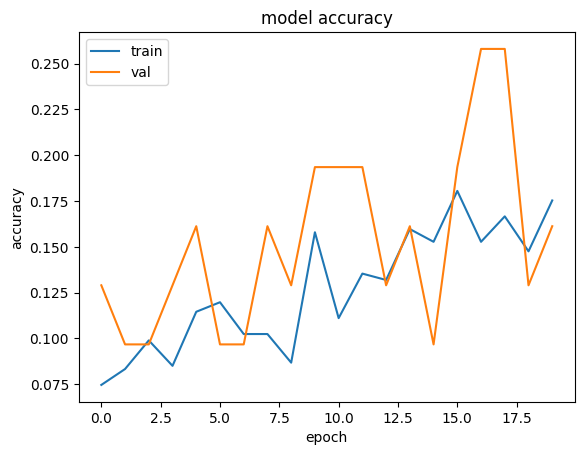

In [27]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
from sklearn.metrics import classification_report

In [29]:
pred = model_clf.predict(X_valid, batch_size=10).argmax(1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


In [30]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

      Бывший СССР       0.00      0.00      0.00         3
   Интернет и СМИ       0.00      0.00      0.00         2
        Экономика       0.00      0.00      0.00         2
              Мир       0.00      0.00      0.00         1
           Россия       0.00      0.00      0.00         2
         Культура       0.50      0.33      0.40         3
  Наука и техника       1.00      0.33      0.50         3
   69-я параллель       0.00      0.00      0.00         1
            Спорт       0.00      0.00      0.00         2
         Из жизни       0.08      0.33      0.13         3
              Дом       0.00      0.00      0.00         2
         Ценности       0.25      0.50      0.33         2
          Легпром       0.00      0.00      0.00         1
       Библиотека       0.00      0.00      0.00         0
Силовые структуры       0.12      0.50      0.20         2
             Крым       0.00      0.00      0.00       

Дообучение с замораживанием может не работать, давайте попробуем обучать все сразу

#### Дообучение без замораживания

In [31]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model_bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
# переводим индекс токена обратно в текст
encoded = tokenizer.encode(data.loc[4, 'title'])
[tokenizer.decode([x]) for x in encoded]

['[CLS]',
 'По',
 'факту',
 'пожара',
 'на',
 'заводе',
 'в',
 'Юг',
 '##ре',
 'заведено',
 'дело',
 '[SEP]']

In [33]:
text = data.loc[4, 'title']
text_ids = tokenizer.encode(text, add_special_tokens=True,
                            return_tensors='pt') # преобразуем в торч формат
output = model_bert(text_ids, output_attentions=False)

In [34]:
output[0].size() # в пайторче вместо .shape используется size()
output[0].shape # но shape тоже работает

torch.Size([1, 12, 768])

In [35]:
output[0][:,0].shape

torch.Size([1, 768])

In [36]:
# переводим тексты в последовательности индексов
# У берта есть ограничение на максимальную длину последовательности - 512
# Для заголовков это не очень актуально, но для других данных пригодится

X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

In [37]:
X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [38]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])


In [39]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [40]:
model_bert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased')
# по умолчанию веса обучаемые поэтому нужно просто загрузить модель

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")

output = bert_wrapper(model_bert)(input_word_ids)
# берем только самый первый вектор (CLS токен)
drop = keras.layers.Dropout(0.1)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(keras.optimizers.Adam(learning_rate=2e-5,
                                    ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [42]:
if torch.cuda.is_available():
    model_clf.to('cuda')

Батч сайз нужно поставить еще меньше

In [44]:
# если есть ошибка с device meta то попробуйте запустить еще раз
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=10)

Epoch 1/10
  1/144 ━━━━━━━━━━━━━━━━━━━━ 1:09 486ms/step - accuracy: 0.5000 - loss: 2.3159 - rec_prec: 0.5000

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['variable_297', 'variable_298'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 65s 451ms/step - accuracy: 0.0762 - loss: 2.8881 - rec_prec: 0.0034 - val_accuracy: 0.0645 - val_loss: 2.7632 - val_rec_prec: 0.0000e+00
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 64s 447ms/step - accuracy: 0.0793 - loss: 2.8013 - rec_prec: 0.0000e+00 - val_accuracy: 0.0645 - val_loss: 2.7734 - val_rec_prec: 0.0000e+00
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 65s 449ms/step - accuracy: 0.0976 - loss: 2.7928 - rec_prec: 0.0023 - val_accuracy: 0.0968 - val_loss: 2.7051 - val_rec_prec: 0.0000e+00
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 65s 448ms/step - accuracy: 0.2375 - loss: 2.4397 - rec_prec: 0.0329 - val_accuracy: 0.7097 - val_loss: 1.0716 - val_rec_prec: 0.6129
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 65s 449ms/step - accuracy: 0.7899 - loss: 0.7191 - rec_prec: 0.7624 - val_accuracy: 0.7419 - val_loss: 0.9444 - val_rec_prec: 0.6452
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 64s 446ms/step - accuracy: 0.9705 - loss: 0.1378 - rec_prec: 0.9981 - val_accuracy: 0.8065

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


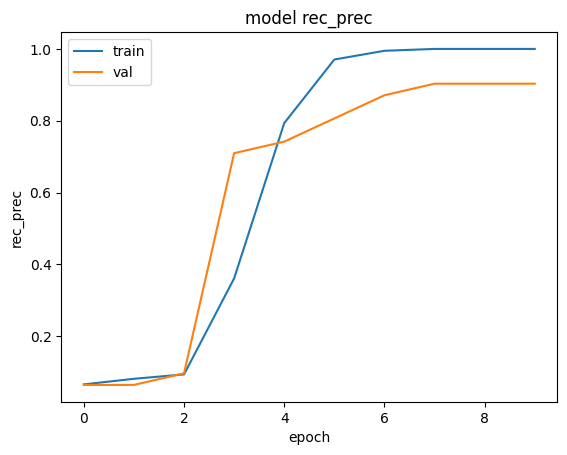

In [45]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
from sklearn.metrics import classification_report

In [47]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


In [48]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

      Бывший СССР       1.00      1.00      1.00         3
   Интернет и СМИ       1.00      1.00      1.00         2
        Экономика       1.00      1.00      1.00         2
              Мир       0.33      1.00      0.50         1
           Россия       0.00      0.00      0.00         2
         Культура       1.00      1.00      1.00         3
  Наука и техника       1.00      1.00      1.00         3
   69-я параллель       1.00      1.00      1.00         1
            Спорт       1.00      1.00      1.00         2
         Из жизни       1.00      0.67      0.80         3
              Дом       1.00      1.00      1.00         2
         Ценности       0.67      1.00      0.80         2
          Легпром       1.00      1.00      1.00         1
       Библиотека       0.00      0.00      0.00         0
Силовые структуры       1.00      1.00      1.00         2
             Крым       0.00      0.00      0.00       

Модель #3

In [49]:
tokenizer = AutoTokenizer.from_pretrained("Twitter/twhin-bert-base")
model_bert = AutoModel.from_pretrained("Twitter/twhin-bert-base")

tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at Twitter/twhin-bert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
# переводим индекс токена обратно в текст
encoded = tokenizer.encode(data.loc[4, 'title'])
[tokenizer.decode([x]) for x in encoded]

['<s>',
 'По',
 'факт',
 'у',
 'пожар',
 'а',
 'на',
 'завод',
 'е',
 'в',
 'Ю',
 'гр',
 'е',
 'за',
 'ведено',
 'дело',
 '</s>']

In [51]:
text = data.loc[4, 'title']
text_ids = tokenizer.encode(text, add_special_tokens=True,
                            return_tensors='pt') # преобразуем в торч формат
output = model_bert(text_ids, output_attentions=False)

In [54]:
output[0].size() # в пайторче вместо .shape используется size()
output[0].shape # но shape тоже работает

torch.Size([1, 17, 768])

In [53]:
output[0][:,0].shape

torch.Size([1, 768])

In [55]:
# переводим тексты в последовательности индексов
# У берта есть ограничение на максимальную длину последовательности - 512
# Для заголовков это не очень актуально, но для других данных пригодится

X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

In [56]:
X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [57]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])


In [58]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [59]:
model_bert = AutoModel.from_pretrained('Twitter/twhin-bert-base')
# по умолчанию веса обучаемые поэтому нужно просто загрузить модель

Some weights of BertModel were not initialized from the model checkpoint at Twitter/twhin-bert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")

output = bert_wrapper(model_bert)(input_word_ids)
# берем только самый первый вектор (CLS токен)
drop = keras.layers.Dropout(0.1)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(keras.optimizers.Adam(learning_rate=2e-5,
                                    ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [61]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [63]:
# если есть ошибка с device meta то попробуйте запустить еще раз
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['variable_300', 'variable_508', 'variable_509'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 81s 562ms/step - accuracy: 0.0944 - loss: 3.0035 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7891 - val_rec_prec: 0.0000e+00
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 79s 548ms/step - accuracy: 0.0791 - loss: 2.8065 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7307 - val_rec_prec: 0.0000e+00
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 79s 547ms/step - accuracy: 0.0846 - loss: 2.8068 - rec_prec: 0.0026 - val_accuracy: 0.0968 - val_loss: 2.7582 - val_rec_prec: 0.0000e+00
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 79s 547ms/step - accuracy: 0.0563 - loss: 2.8087 - rec_prec: 3.0117e-05 - val_accuracy: 0.0968 - val_loss: 2.7279 - val_rec_prec: 0.0000e+00
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 79s 547ms/step - accuracy: 0.0853 - loss: 2.7637 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7210 - val_rec_prec: 0.0000e+00
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 79s 547ms/step - accuracy: 0.0918 - loss: 2.7575 - rec_prec: 9.9812e-0

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


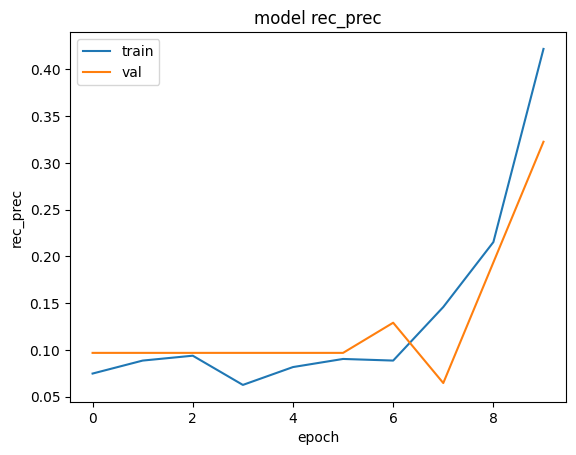

In [64]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [65]:
from sklearn.metrics import classification_report

In [66]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


In [67]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

      Бывший СССР       0.25      0.33      0.29         3
   Интернет и СМИ       0.00      0.00      0.00         2
        Экономика       0.00      0.00      0.00         2
              Мир       0.00      0.00      0.00         1
           Россия       0.00      0.00      0.00         2
         Культура       0.67      0.67      0.67         3
  Наука и техника       0.67      0.67      0.67         3
   69-я параллель       0.00      0.00      0.00         1
            Спорт       0.12      0.50      0.20         2
         Из жизни       0.00      0.00      0.00         3
              Дом       0.00      0.00      0.00         2
         Ценности       1.00      0.50      0.67         2
          Легпром       0.00      0.00      0.00         1
       Библиотека       0.00      0.00      0.00         0
Силовые структуры       1.00      0.50      0.67         2
             Крым       0.00      0.00      0.00       

Еще модель

In [68]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")
model_bert = AutoModel.from_pretrained("google-bert/bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [69]:
# переводим индекс токена обратно в текст
encoded = tokenizer.encode(data.loc[4, 'title'])
[tokenizer.decode([x]) for x in encoded]

['[CLS]',
 'По',
 'факт',
 '##у',
 'по',
 '##жар',
 '##а',
 'на',
 'заводе',
 'в',
 'Ю',
 '##гр',
 '##е',
 'за',
 '##ведено',
 'дело',
 '[SEP]']

In [70]:
text = data.loc[4, 'title']
text_ids = tokenizer.encode(text, add_special_tokens=True,
                            return_tensors='pt') # преобразуем в торч формат
output = model_bert(text_ids, output_attentions=False)

In [71]:
output[0].size() # в пайторче вместо .shape используется size()
output[0].shape # но shape тоже работает

torch.Size([1, 17, 768])

In [72]:
# переводим тексты в последовательности индексов
# У берта есть ограничение на максимальную длину последовательности - 512
# Для заголовков это не очень актуально, но для других данных пригодится

X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

In [73]:
X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [74]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])


In [75]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [76]:
model_bert = AutoModel.from_pretrained('google-bert/bert-base-multilingual-cased')
# по умолчанию веса обучаемые поэтому нужно просто загрузить модель

In [77]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")

output = bert_wrapper(model_bert)(input_word_ids)
# берем только самый первый вектор (CLS токен)
drop = keras.layers.Dropout(0.1)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(keras.optimizers.Adam(learning_rate=2e-5,
                                    ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [78]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [80]:
# если есть ошибка с device meta то попробуйте запустить еще раз
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['variable_707', 'variable_708'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 65s 452ms/step - accuracy: 0.0899 - loss: 2.9154 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7530 - val_rec_prec: 0.0000e+00
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 441ms/step - accuracy: 0.0743 - loss: 2.8280 - rec_prec: 0.0039 - val_accuracy: 0.0968 - val_loss: 2.7171 - val_rec_prec: 0.0000e+00
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 64s 441ms/step - accuracy: 0.0576 - loss: 2.7752 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7390 - val_rec_prec: 0.0000e+00
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 64s 443ms/step - accuracy: 0.0641 - loss: 2.7661 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7209 - val_rec_prec: 0.0000e+00
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 63s 441ms/step - accuracy: 0.0862 - loss: 2.7627 - rec_prec: 0.0038 - val_accuracy: 0.0645 - val_loss: 2.6893 - val_rec_prec: 0.0000e+00
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 64s 443ms/step - accuracy: 0.1010 - loss: 2.7630 - rec_prec: 5.7471e-04 - 

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


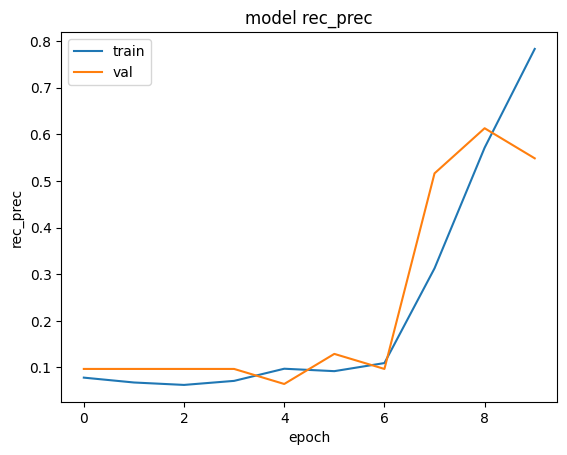

In [81]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [82]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


In [83]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

      Бывший СССР       0.00      0.00      0.00         3
   Интернет и СМИ       0.50      1.00      0.67         2
        Экономика       1.00      0.50      0.67         2
              Мир       0.00      0.00      0.00         1
           Россия       0.40      1.00      0.57         2
         Культура       1.00      0.67      0.80         3
  Наука и техника       0.40      0.67      0.50         3
   69-я параллель       0.00      0.00      0.00         1
            Спорт       0.67      1.00      0.80         2
         Из жизни       1.00      0.67      0.80         3
              Дом       1.00      1.00      1.00         2
         Ценности       1.00      0.50      0.67         2
          Легпром       0.00      0.00      0.00         1
       Библиотека       0.00      0.00      0.00         0
Силовые структуры       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00       